In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [121]:
import numpy as np 
from scipy.stats import norm
from math import log, sqrt, exp
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam





In [3]:
def bs_call_price(S, K, r, sigma, t, T):
    """
    Black–Scholes formula for a European call option.
    S: current underlying price
    K: strike
    r: risk-free rate
    sigma: volatility
    t: current time
    T: maturity time
    """
    tau = T - t  # time to maturity
    if tau <= 0:
        return max(S - K, 0)  # option payoff at/after maturity
    
    d1 = (log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*sqrt(tau))
    d2 = d1 - sigma*sqrt(tau)
    
    call = S*norm.cdf(d1) - K*exp(-r*tau)*norm.cdf(d2)
    return call

def bs_call_delta(S, K, r, sigma, t, T):
    """
    Delta for a European call option (partial derivative of price wrt S).
    """
    tau = T - t
    if tau <= 0:
        return (S>K)* 1.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)


In [20]:

# ------------------------------
# Parameters for the simulation
# ------------------------------
S0 = 100.0      # initial underlying price
K  = 100.0      # strike
r  = 0.02       # annual risk-free rate
sigma = 0.20    # volatility (20%)
T  = 1.0        # maturity in years (1 year)
steps = 20     # number of discrete hedging steps
dt = T / steps  # length of each time step
nb_simul = 10000
costs = [0.0,0.001,0.002,0.005]



 ...]

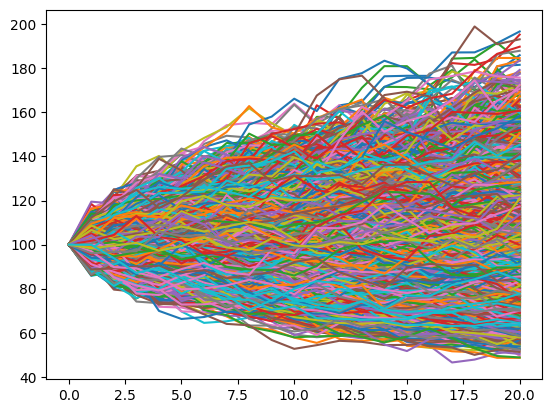

In [21]:
#Simulated path 
def simulation_path(S0,K,r,sigma,steps,nb_simul):
    times = np.linspace(0, T, steps+1)
    Z = np.random.normal(0,1,(nb_simul,steps+1))
    Z = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    Z[:,0]=S0
    Z = Z.cumprod(axis = 1)
    return(Z.T)
plt.plot(simulation_path(S0,K,r,sigma,steps,nb_simul))

In [16]:
"""
# ----------------------
# Delta-hedging
# ----------------------
# We SELL 1 call option at t=0, so we get its premium initially.
premium = bs_call_price(S0, K, r, sigma, 0.0, T)"""
final_portfolios_values = []
for cost in costs : 
    # Our hedge: we hold Delta shares of the underlying (continuously updated).
    # Start: compute initial delta at t=0
    delta_old = bs_call_delta(S0, K, r, sigma, 0.0, T)
    premium = bs_call_price(S0, K, r, sigma, 0.0, T)
    # We'll track the value of our hedging portfolio:
    #   - "option value" is negative (we sold the call).
    #   - "stock holding" is delta shares.
    #   - "cash" starts with the option premium minus the cost to buy delta shares.
    portfolio_value = premium - delta_old*S0
    # To keep track of PnL, note that at each step we:
    #  - Revalue the option
    #  - Rebalance the hedge (update delta)
    #  - Gains/losses go into portfolio_value
    for i in range(1, steps+1):
        t = times[i]
        # New delta
        delta_new = bs_call_delta(Z[:,i], K, r, sigma, t, T)
        
        # Rebalance cost: We go from delta_old shares to delta_new shares.
        # The price of the shares is S[i]. 
        # So the immediate cashflow from rebalancing is: (delta_old - delta_new)*S[i]
        # (If delta_new > delta_old, we are buying shares, so we spend money (negative).)
        rebalance_cashflow = (delta_old - delta_new)*Z[:,i] - cost*np.abs((delta_old - delta_new)*Z[:,i])
        
        # Update portfolio value by that cashflow
        portfolio_value += rebalance_cashflow
        # Move forward in time: accrue risk-free interest over dt
        # (Very rough discrete approximation: portfolio_value *= exp(r*dt))
        # We'll do that only if we want to incorporate interest on any cash part:
        portfolio_value *= exp(r*dt)
        
        # Update old delta
        delta_old = delta_new

    # ---------------------------
    # Final payout of the option
    # ---------------------------
    # At maturity, the call option we sold costs us: payoff = max(S(T) - K, 0).
    final_option_payoff = (Z[:,-1]-K >0)*(Z[:,-1]-K) 

    # The final stock holding is delta_old shares worth delta_old * S[-1].
    # We can liquidate them at maturity. So the final net in the portfolio is:
    final_portfolio_value = portfolio_value + delta_old * Z[:,-1] - final_option_payoff -cost*delta_old * Z[:,-1]
    final_portfolios_values.append(final_portfolio_value)

In [7]:
pip install nbformat==4.2.0

  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.4
    Uninstalling nbformat-5.10.4:
      Successfully uninstalled nbformat-5.10.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 2.14.2 requires nbformat>=5.3.0, but you have nbformat 4.2.0 which is incompatible.
nbclient 0.10.0 requires nbformat>=5.1, but you have nbformat 4.2.0 which is incompatible.
nbconvert 7.16.4 requires nbformat>=5.7, but you have nbformat 4.2.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import plotly.graph_objects as go


In [17]:
fig = go.Figure()
for i in range(len(costs)):

    fig.add_trace(go.Histogram(x=final_portfolios_values[i]))

# Overlay both histograms
fig.update_layout(barmode = 'overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# Make the plot for delta for different time to maturity and different stike 

# try to construct a small neural network that takes time to matuirity and moneyness and get the delta 

In [80]:
# We areg goin to construct a small neural networks that takes in input time to matuirity and moneyness and get the delta back 
# First we construct our train set 
# We are going to try with 20 periods 
S = simulation_path(S0,K,r,sigma,steps,nb_simul)
ttm = list(np.linspace(0,20,21,dtype ='int'))
l = [[time,s] for (time,s) in zip(ttm,S)]
dataset = np.zeros(((steps+1)*nb_simul,3))

In [81]:
dataset[:,0] = ttm*nb_simul
dataset[:,1] = S.T.reshape(210000,)
dataset[:,2] = [bs_call_delta(dataset[i,1],K,r,sigma,dataset[i,0],20) for i in range((nb_simul*(steps+1)))]


In [82]:
dataset[:,1] = np.log(dataset[:,1]/K)

# Buil a neural network to predict y 

In [106]:
X = dataset[:,:2]
X.shape

(210000, 2)

In [122]:

model = keras.Sequential([
    layers.Dense(32,input_shape=(2,)),  
    layers.BatchNormalization(),                         
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(64, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(32, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Output layer with 1 neuron (sigmoid -> output in [0, 1])
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['accuracy'])

# 4. Train the model
history = model.fit(
    X, Y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

# 5. Evaluate on the entire dataset
loss, accuracy = model.evaluate(X, Y, verbose=0)
print(f"Final Training Loss: {loss:.4f}")
print(f"Final Training Accuracy: {accuracy:.4f}")


Epoch 1/10


/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5250/5250 ━━━━━━━━━━━━━━━━━━━━ 6s 808us/step - accuracy: 0.0407 - loss: 0.0170 - val_accuracy: 0.0469 - val_loss: 0.0027
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 808us/step - accuracy: 0.0444 - loss: 0.0065 - val_accuracy: 0.0461 - val_loss: 0.0022
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 748us/step - accuracy: 0.0440 - loss: 0.0056 - val_accuracy: 0.0474 - val_loss: 0.0023
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 753us/step - accuracy: 0.0450 - loss: 0.0052 - val_accuracy: 0.0465 - val_loss: 0.0019
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 780us/step - accuracy: 0.0448 - loss: 0.0050 - val_accuracy: 0.0427 - val_loss: 0.0053
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 758us/step - accuracy: 0.0455 - loss: 0.0048 - val_accuracy: 0.0475 - val_loss: 0.0012
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 4s 768us/step - accuracy: 0.0445 - loss: 0.0047 - val_accuracy: 0.0469 - val_loss: 0.0024
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 5s 856us/step - accuracy: 0.0450 - loss: 0.00